In [141]:
# Load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim
import gensim
from wordcloud import WordCloud, STOPWORDS

from collections import defaultdict, Counter
import string
from sklearn.feature_extraction.text import CountVectorizer


%matplotlib inline

In [27]:
# load train data
train = pd.read_csv('Data\\train.csv')
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [28]:
# replace na
train['text'] = train['text'].replace(np.nan, train['title'])
train['title'] = train['title'].replace(np.nan, train['text'])

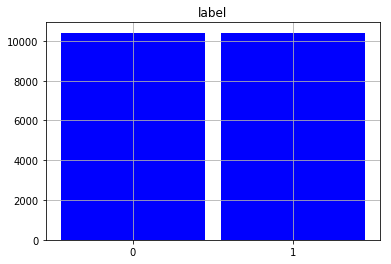

In [4]:
# Class balance analysis
train[['label']].hist(bins = 3)
plt.bar(np.arange(len([0,1])), train.groupby(['label']).size().values, 0.9,  color="blue")
plt.xticks(np.arange(len([0,1])), [0,1])
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017E1CA8C4A8>,
      dtype=object)

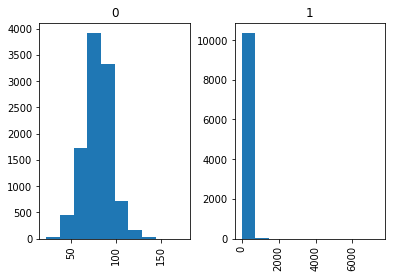

In [5]:
#  the number of characters present in each title by labels
train['title'].str.len().hist(by=train['label'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017E155E50F0>,
      dtype=object)

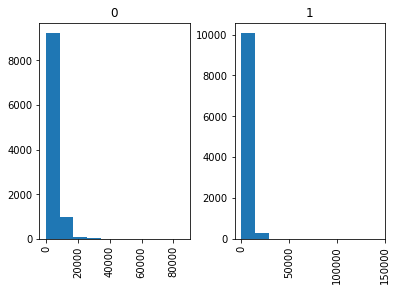

In [6]:
#  the number of characters present in each text by labels
train['text'].str.len().hist(by=train['label'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017E1E679780>,
      dtype=object)

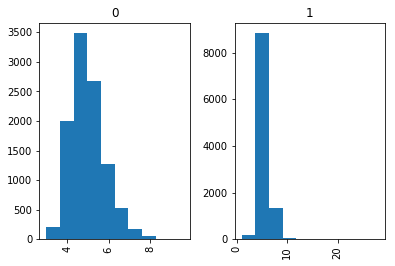

In [7]:
# Word level analysis of title
train['title'].str.split().apply(lambda x:[len(i) for i in x]).map(lambda x: np.mean(x)).hist(by=train['label'])

C:\Anaconda\envs\py35\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda\envs\py35\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017E1E738F28>,
      dtype=object)

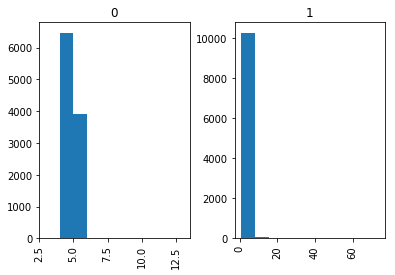

In [8]:
# Word level analysis of title
train['text'].str.split().apply(lambda x:[len(i) for i in x]).map(lambda x: np.mean(x)).hist(by=train['label'])

In [108]:
# Remove stopwords from title and text by label
messages_fake=messages[messages.label==1].copy()
messages_not_fake=messages[messages.label==0].copy()

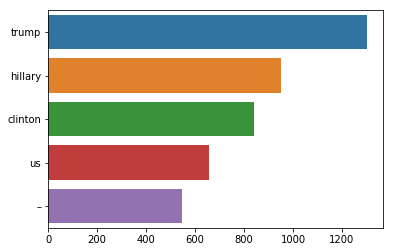

In [109]:
# Corpus analysis corpus_title_fake
stop=set(stopwords.words('english'))
messages_fake['title'] = messages_fake['title'].str.lower()
messages_fake['title'] = messages_fake.title.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
new = messages_fake['title'].str.split()
new=new.values.tolist()
corpus_title_fake=[word for i in new for word in i]

counter=Counter(corpus_title_fake)
most=counter.most_common()
x, y= [], []
for word,count in most[:25]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

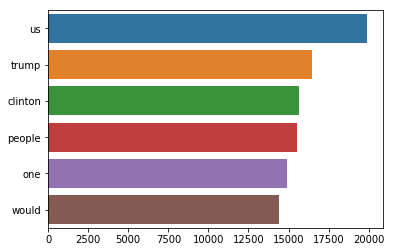

In [110]:
# Corpus analysis corpus_text_fake
stop=set(stopwords.words('english'))
messages_fake['text'] = messages_fake['text'].str.lower()
messages_fake['text'] = messages_fake.text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
new = messages_fake['text'].str.split()
new=new.values.tolist()
corpus_text_fake=[word for i in new for word in i]

counter=Counter(corpus_text_fake)
most=counter.most_common()
x, y= [], []
for word,count in most[:50]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

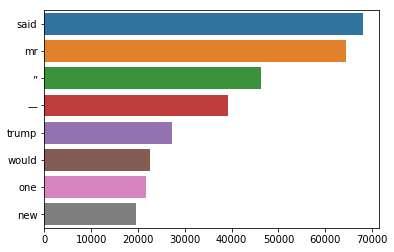

In [111]:
# Corpus analysis corpus_title_not_fake
stop=set(stopwords.words('english'))
messages_not_fake['title'] = messages_not_fake['text'].str.lower()
messages_not_fake['title'] = messages_not_fake.title.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
new = messages_not_fake['title'].str.split()
new=new.values.tolist()
corpus_title_not_fake=[word for i in new for word in i]

counter=Counter(corpus_title_not_fake)
most=counter.most_common()
x, y= [], []
for word,count in most[:50]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

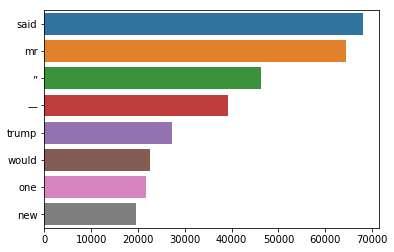

In [112]:
# Corpus analysis corpus_text_not_fake
stop=set(stopwords.words('english'))
messages_not_fake['text'] = messages_not_fake['text'].str.lower()
messages_not_fake['text'] = messages_not_fake.text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
new = messages_not_fake['text'].str.split()
new=new.values.tolist()
corpus_text_not_fake=[word for i in new for word in i]

counter=Counter(corpus_text_not_fake)
most=counter.most_common()
x, y= [], []
for word,count in most[:50]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

In [113]:
# Ngram analysis function

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

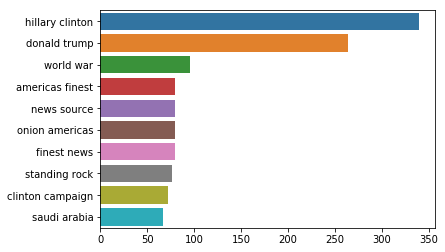

In [114]:
# Ngram analysis corpus_title_fake

messages_fake['title'] = messages_fake['title'].str.lower()
messages_fake['title'] = messages_fake.title.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
messages_fake['title'] = messages_fake['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

top_n_bigrams=get_top_ngram(messages_fake['title'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

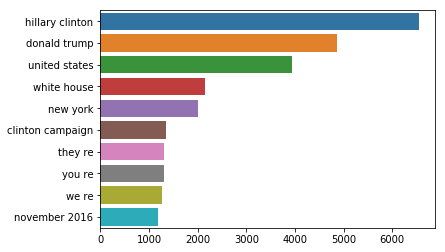

In [115]:
# Ngram analysis corpus_text_fake

messages_fake['text'] = messages_fake['text'].str.lower()
messages_fake['text'] = messages_fake.text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
messages_fake['text'] = messages_fake['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

top_n_bigrams=get_top_ngram(messages_fake['text'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

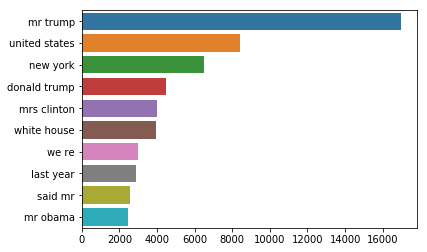

In [116]:
# Ngram analysis corpus_title_not_fake

messages_not_fake['title'] = messages_not_fake['title'].str.lower()
messages_not_fake['title'] = messages_not_fake.title.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
messages_not_fake['title'] = messages_not_fake['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

top_n_bigrams=get_top_ngram(messages_not_fake['title'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

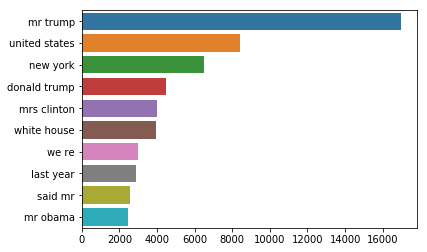

In [118]:
# Ngram analysis corpus_text_not_fake

messages_not_fake['text'] = messages_not_fake['text'].str.lower()
messages_not_fake['text'] = messages_not_fake.text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
messages_not_fake['text'] = messages_not_fake['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

top_n_bigrams=get_top_ngram(messages_not_fake['text'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

In [126]:
#  Preprocess function for LDA
nltk.download('punkt')
nltk.download('wordnet')

def preprocess_news(df,column):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in df[column]:
        words=[w for w in word_tokenize(news) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anshch\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anshch\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [132]:
#LDA for corpus_title_fake
corpus = preprocess_news(messages_fake,'title')
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

[(0,
  '0.028*"hillary" + 0.026*"trump" + 0.023*"clinton" + 0.009*"email" + 0.008*"video" + 0.008*"fbi" + 0.007*"election" + 0.006*"donald" + 0.006*"news" + 0.005*"breaking"'),
 (1,
  '0.014*"trump" + 0.011*"russia" + 0.011*"war" + 0.006*"new" + 0.006*"world" + 0.005*"time" + 0.005*"american" + 0.005*"hillary" + 0.005*"obama" + 0.004*"people"'),
 (2,
  '0.008*"trump" + 0.006*"white" + 0.006*"one" + 0.004*"election" + 0.004*"people" + 0.004*"clinton" + 0.003*"comment" + 0.003*"think" + 0.003*"house" + 0.003*"say"'),
 (3,
  '0.006*"election" + 0.006*"syria" + 0.006*"america" + 0.006*"war" + 0.005*"saudi" + 0.004*"trump" + 0.004*"source" + 0.003*"state" + 0.003*"news" + 0.003*"said"')]

In [137]:
#Vizual for corpus_title_fake
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
pyLDAvis.save_html(vis, 'lda_fake_title.html')

C:\Anaconda\envs\py35\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [138]:
#LDA for corpus_title_not_fake
corpus = preprocess_news(messages_not_fake,'title')
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
pyLDAvis.save_html(vis, 'lda_not_fake_title.html')
lda_model.show_topics()

C:\Anaconda\envs\py35\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


[(0,
  '0.014*"said" + 0.011*"state" + 0.008*"trump" + 0.007*"united" + 0.006*"president" + 0.006*"government" + 0.006*"country" + 0.005*"would" + 0.005*"american" + 0.004*"official"'),
 (1,
  '0.019*"trump" + 0.012*"said" + 0.007*"president" + 0.006*"republican" + 0.006*"would" + 0.006*"clinton" + 0.005*"people" + 0.004*"one" + 0.004*"news" + 0.004*"campaign"'),
 (2,
  '0.018*"said" + 0.006*"police" + 0.006*"one" + 0.005*"year" + 0.004*"people" + 0.004*"two" + 0.004*"state" + 0.004*"city" + 0.004*"time" + 0.003*"officer"'),
 (3,
  '0.011*"said" + 0.006*"year" + 0.006*"new" + 0.005*"one" + 0.005*"company" + 0.005*"like" + 0.005*"time" + 0.004*"would" + 0.004*"people" + 0.003*"also"')]

In [139]:
#LDA for corpus_text_fake
corpus = preprocess_news(messages_fake,'text')
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
pyLDAvis.save_html(vis, 'lda_fake_text.html')
lda_model.show_topics()

C:\Anaconda\envs\py35\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


[(0,
  '0.008*"russia" + 0.007*"war" + 0.005*"russian" + 0.005*"state" + 0.005*"syria" + 0.004*"country" + 0.004*"military" + 0.004*"would" + 0.004*"said" + 0.004*"world"'),
 (1,
  '0.010*"que" + 0.007*"что" + 0.005*"los" + 0.004*"del" + 0.004*"это" + 0.003*"vaccine" + 0.003*"la" + 0.003*"как" + 0.003*"por" + 0.003*"para"'),
 (2,
  '0.010*"clinton" + 0.005*"hillary" + 0.005*"one" + 0.005*"people" + 0.005*"email" + 0.004*"would" + 0.004*"time" + 0.004*"state" + 0.003*"new" + 0.003*"like"'),
 (3,
  '0.014*"trump" + 0.005*"people" + 0.005*"election" + 0.005*"one" + 0.004*"would" + 0.004*"said" + 0.004*"state" + 0.004*"donald" + 0.004*"clinton" + 0.004*"time"')]

In [140]:
#LDA for corpus_text_not_fake
corpus = preprocess_news(messages_not_fake,'text')
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
pyLDAvis.save_html(vis, 'lda_not_fake_text.html')
lda_model.show_topics()

C:\Anaconda\envs\py35\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


[(0,
  '0.017*"said" + 0.007*"company" + 0.007*"year" + 0.005*"would" + 0.005*"new" + 0.005*"percent" + 0.005*"state" + 0.004*"one" + 0.004*"people" + 0.004*"million"'),
 (1,
  '0.022*"trump" + 0.014*"said" + 0.009*"president" + 0.006*"would" + 0.006*"state" + 0.005*"republican" + 0.005*"clinton" + 0.004*"obama" + 0.004*"people" + 0.004*"campaign"'),
 (2,
  '0.017*"said" + 0.007*"state" + 0.006*"police" + 0.005*"people" + 0.004*"one" + 0.004*"year" + 0.004*"official" + 0.004*"attack" + 0.003*"government" + 0.003*"city"'),
 (3,
  '0.010*"said" + 0.007*"one" + 0.006*"like" + 0.005*"time" + 0.005*"year" + 0.005*"new" + 0.003*"people" + 0.003*"would" + 0.003*"first" + 0.003*"day"')]

In [142]:
# Function for word cloud
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

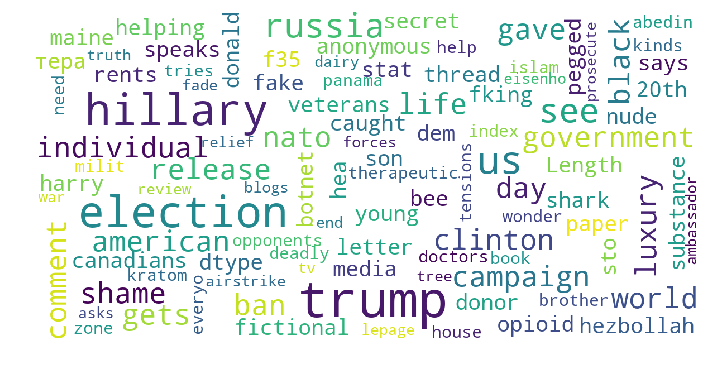

In [145]:
# Word cloud for corpus_title_fake
show_wordcloud(messages_fake['title'])

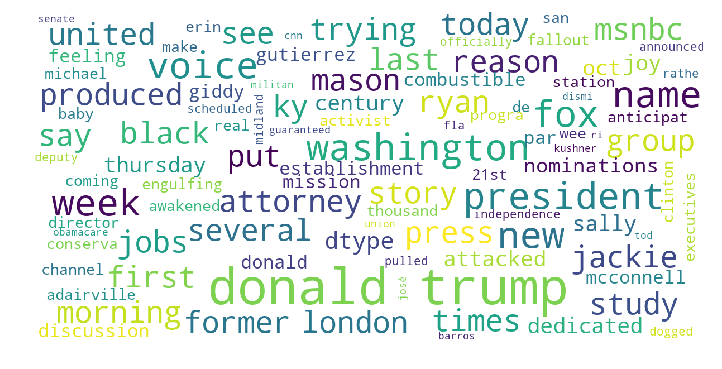

In [146]:
# Word cloud for corpus_title_not_fake
show_wordcloud(messages_not_fake['title'])

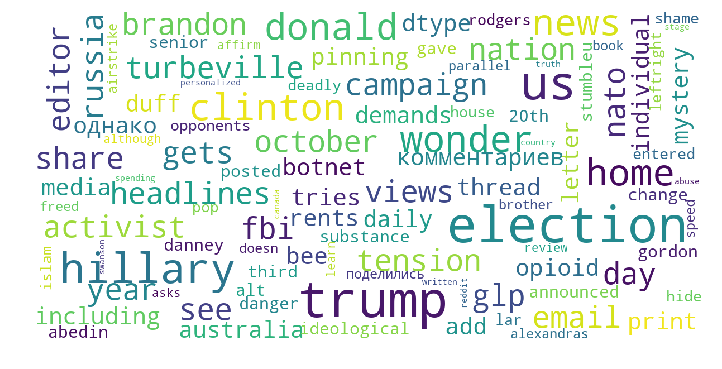

In [147]:
# Word cloud for corpus_text_fake
show_wordcloud(messages_fake['text'])

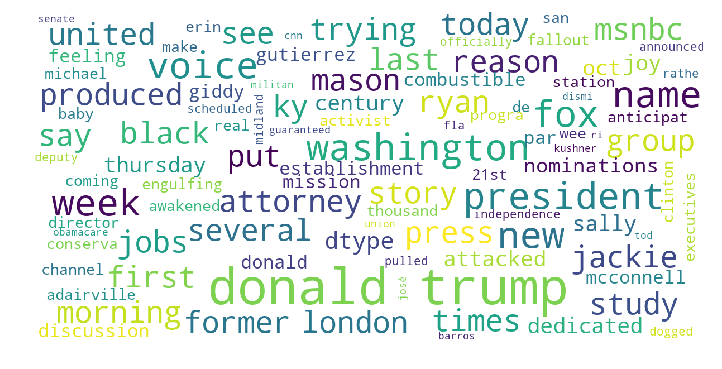

In [148]:
# Word cloud for corpus_text_not_fake
show_wordcloud(messages_not_fake['text'])